In [53]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from scipy.optimize import newton

save_plots = False

In [2]:
## Physical constants used below
vH = 246  # GeV
MZ = 91.2   # GeV
MW = 80.4   # GeV
mH = 125.20 # GeV
Gamma_W_tot = 2.085  # total decay width, GeV

GeV_to_s = 6.58e-25
sec_to_yr = 3.171e-8

SM_masses = {       ## SM fermions, all masses GeV
    'e': 0.000511,
    'mu': 0.10566,
    'tau': 1.777,
    'c': 1.27,
    'b': 4.18,
}

SM_Nc = {           ## Color-counting factor for certain decay formulas below
    'e': 1,
    'mu': 1,
    'tau': 1,
    'c': 3,
    'b': 3,
}

In [3]:
## Global model defaults

ND_default = 4
m_eq_default = 3000 # GeV
eps_default = 0.5

## Meson and baryon masses

For derivation of these mass formulas, see the paper and the companion notebook `mass-ranges`.  In all cases, the $\sigma_d$ meson mass is estimated to be

$$
M_{\sigma_d} \approx \frac{2}{N_D} M_{B_d}.
$$

The reference model has relatively light quarks, and the other two meson masses are estimated as
$$
M_{\eta'_d}^{({\rm ref})} \approx \frac{2}{N_D} M_{B_d}, \\
M_{0^{++}_d}^{({\rm ref})} \approx M_{B_d}.
$$

At the reference point, the $\eta'_d$ mass is somewhat uncertain, and we take it to vary over the range $N_D/3 \lesssim M_{B_d} / M_{\eta'_d} \lesssim 2N_D/3$.

Finally, we consider a "heavy-quark" point for the model, at which the glueball is relatively light:
$$
M_{\eta'_d}^{({\rm HQ})} \approx \frac{2}{N_D} M_{B_d} \\
M_{0^{++}_d}^{({\rm HQ})} \approx \frac{1}{N_D} M_{B_d}.
$$

Each meson has an associated decay constant that is required to compute its decay width.  The formulas, collected from the paper, are:

$$
f_{\eta'_d} = \frac{1}{2} \sqrt{\frac{N_D}{3}} M_{\eta'_d} \\
\mathbf{\alpha_d F_{0^{++}}^{S}} = \frac{3.1}{4\pi} \frac{N_D}{3} M_{0^{++}_d}^3 \\
\mathbf{F_{\sigma}} = \sqrt{\frac{N_D}{3}} \chi_\sigma M_{\sigma_d}^2
$$
where $\chi_\sigma$ is an order-1 number, and $\alpha_d$ is the dark gauge coupling constant which cancels out in the actual decay-width formula.


In [4]:
def eta_mass_F(M_Bd, r_Bd_eta=0.5, ND=ND_default, HQ=False, **kwargs):
    # r_Bd_eta should vary from 1/3 to 2/3
    assert 0.3 < r_Bd_eta < 0.7
    
    if HQ:
        M_eta = M_Bd / ND * 2
    else:
        M_eta = M_Bd / ND / r_Bd_eta
    
    f_eta = M_eta * 0.5 * np.sqrt(ND/3)
    
    return np.asarray(M_eta), np.asarray(f_eta)

def glueball_mass_F(M_Bd, r_Bd_eta=0.5, ND=ND_default, HQ=False, **kwargs):
    if HQ:
        # M_0++ ~ M_eta_d / 2 ~ M_Bd / ND
        M_0 = M_Bd / ND
    else:
        # M_0++ ~ M_Bd
        M_0 = M_Bd

    F_0 = 3.1 / (4*np.pi)
    F_0 *= (ND/3)
    F_0 *= M_0**3
    
    return np.asarray(M_0), np.asarray(F_0)
        
def sigma_mass_F(M_Bd, chi_sigma=1.0, ND=ND_default, **kwargs):
    M_sigma = (2/ND) * M_Bd
    f_sigma = np.sqrt(ND/3) * chi_sigma * M_sigma**2

    return np.asarray(M_sigma), np.asarray(f_sigma)

# Inverse functions, for plotting purposes
def mass_eta_to_Bd(M_eta, r_Bd_eta=0.5, ND=ND_default, HQ=False, **kwargs):
    if HQ:
        return M_eta * ND / 2
    else:
        return ND * r_Bd_eta * M_eta
    
def mass_sigma_to_Bd(M_sigma, ND=ND_default, **kwargs):
    return M_sigma * ND / 2

def mass_glueball_to_Bd(M_0, r_Bd_eta=0.5, ND=ND_default, HQ=False, **kwargs):
    if HQ:
        return M_0 * ND
    else:
        return M_0
        

## ALP-like decay rates for etas

The details of this derivation now all appear in the paper draft.  The resulting formula is:

$$
\Gamma(\eta' \rightarrow f \bar{f}) = \frac{N_C^f N_D}{32\pi} M_{\eta'} \theta^4 \epsilon^4 \frac{m_f^2 f_{\eta'}^2}{M_Z^4} \sqrt{1 - \frac{4m_f^2}{M_\eta'^2}} .
$$


### Other hadronic decays?

Referring to 1708.00443, the dominant hadronic decay mode at light $\eta'$ masses is $\eta' \rightarrow 3\pi$.  From eq.(27) of the reference, there are two contributions.  One is proportional to the $\eta' G \tilde{G}$ coupling, $C_{GG}$; for hyperstealth DM this coupling is extremely suppressed and we can set it to zero.  The other contribution is proportional to $(c_{uu} - c_{dd})^2$, where the quark-$\eta'$ couplings are defined as above.  Since these couplings factor out the Yukawas, they are _equal_ in our model as written, $c_{uu} = c_{dd}$, so this contribution is also zero.  Therefore,

$$
\Gamma(\eta' \rightarrow \pi \pi \pi) \approx 0.
$$

There is another decay channel, denoted "$a \rightarrow$ hadrons" in the reference, but this requires being in the "perturbative regime" for QCD since it is a one-loop estimate, and it is again dominated by the $C_{GG}$ coupling.  So for our purposes, I will neglect these other hadronic decays in what follows.  When we reconsider BBN bounds I will include a very crude estimate for what low-mass hadronic decay modes would result in.

We adopt the following formulas for the $\eta'$ mass and decay constant:

$$
\frac{M_{B_d}}{M_{\eta'}} \approx \frac{N_D}{2}; \\
\frac{N_D}{3} \leq \frac{M_{B_d}}{M_{\eta'}} \leq \frac{2N_D}{3}; \\
\frac{f_{\eta'}}{M_{\eta'}} \approx \frac{1}{2} \sqrt{\frac{N_D}{3}}.
$$

For BBN bounds (hep-ph/0604251), the hadronic branching fraction of the $\eta'$ is relevant.  I will count c/b decays as 100% hadronic, and tau decays as 65% hadronic (since they go to leptons 35% of the time.)

__Important note:__ the parameter `r_Bd_eta` is the ratio of the baryon to $\eta'$ mass, _with the factor of $N_c$ removed._  For example, at $N_c = 4$ the value `r_Bd_eta = 0.5` corresponds to $M_{B_d} / M_{\eta'_d} = 0.5 N_c = 2$.  Use the function defined below to get it right!

In [5]:
def Gamma_eta_prime(theta, M_Bd, r_Bd_eta=0.5, eps=eps_default, ND=ND_default, HQ=False, return_had_frac=False):

    M_eta, f_eta = eta_mass_F(M_Bd, r_Bd_eta=r_Bd_eta, ND=ND, HQ=HQ)
    
    base_gamma = 1 / (8 * np.pi)
    base_gamma *= eps**4
    base_gamma *= theta**4
    base_gamma *= M_eta
    base_gamma *= (f_eta / MZ)**2
    
    gamma = 0.0
    gamma_had = 0.0
    
    for F in SM_masses.keys():
        mF = SM_masses[F]
        th_mask = 2*SM_masses[F] < M_eta

        if F == 'c' or F =='b':
            had_frac = 1.0
        elif F == 'tau':
            had_frac = 0.65
        else:
            had_frac = 0.0
        
        gamma_F = base_gamma * (mF / MZ)**2 * np.ones_like(M_Bd)
        gamma_F *= SM_Nc[F]
        
        gamma_F[th_mask] *= np.sqrt(1 - 4 * mF**2 / (M_eta[th_mask])**2)
        gamma_F[~th_mask] *= 0
        
        gamma += gamma_F
        gamma_had += gamma_F * had_frac
    
    if return_had_frac:
        return gamma_had / np.where(gamma>0, gamma, gamma+1.0)
    else:
        return gamma
    
def ctau_eta_prime(theta, M_Bd, r_Bd_eta=0.5, eps=eps_default, ND=4, HQ=False):
    gamma = Gamma_eta_prime(theta, M_Bd, r_Bd_eta=r_Bd_eta, eps=eps, ND=ND, HQ=HQ)
    
    ctau = 1/gamma * GeV_to_s
    
    return ctau
    

Text(0, 0.5, "$\\Gamma_{\\eta'}$ (GeV)")

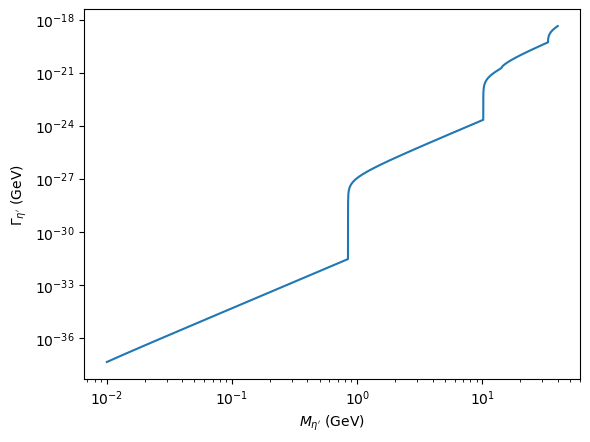

In [6]:
mx = np.linspace(5e-3,20,20000)
G = Gamma_eta_prime(1e-3, mx)

plt.plot(2*mx, G)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("$M_{\\eta'}$ (GeV)")
plt.ylabel("$\\Gamma_{\\eta'}$ (GeV)")

Text(0, 0.5, "$c \\tau_{\\eta'}$ (s)")

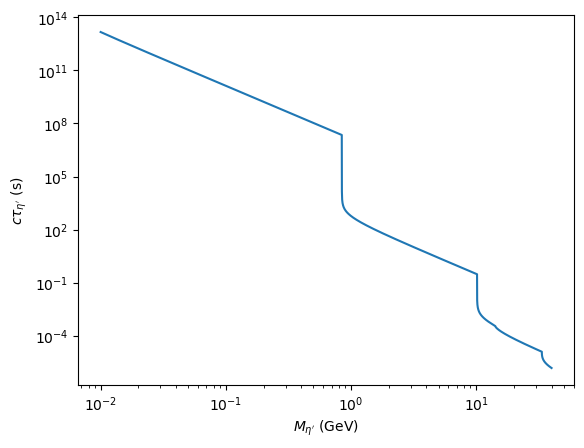

In [7]:
mx = np.linspace(5e-3,20,20000)
ctau = ctau_eta_prime(1e-3, mx)

plt.plot(2*mx, ctau)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("$M_{\\eta'}$ (GeV)")
plt.ylabel("$c \\tau_{\\eta'}$ (s)")

Text(0.5, 0, "$M_{\\eta'} (GeV)$")

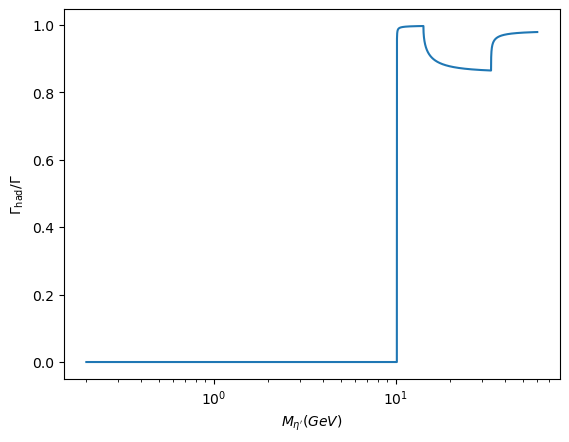

In [8]:
## Show hadronic branching fraction
mx = np.linspace(1e-1,30,20000)
H = Gamma_eta_prime(1e-3, mx, return_had_frac=True)

plt.plot(2*mx, H)
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('$\Gamma_{\\rm had} / \Gamma$')
plt.xlabel("$M_{\\eta'} (GeV)$")

## Glueball decay

From the draft, the glueball decay width is:
$$
\Gamma_{0^{++},\rm tot} \;=\; \frac{4 \alpha_d^2}{9 \pi^2} \theta^4 \frac{(F_{0^{++}}^{S})^2}{v^2 (m_h^2 - m_{0^{++}}^2)^2}
\Gamma^{\rm SM}_{h,{\rm tot}}(m_{0^{++}}^2) \, .
$$

As with the $\eta'_d$ above, the total decay width will depend on what thresholds are open as a function of $m_{0^{++}}$.  The decay constant $F_{0^{++}}^{S}$ is computed above.

For the range of glueball masses we consider, the dominant branching of the Higgs (and thus the $0^{++}$ glueball) will usually be into pairs of quarks or leptons, as with the $\eta'_d$.  From the Higgs Hunters' Guide, we have:

$$
\Gamma(h \rightarrow \bar{f} f) = \frac{N_c^f g^2 m_f^2}{32\pi m_W^2} m_h \left( 1 - \frac{4m_f^2}{m_h^2}\right)^{3/2}.
$$
Let's rewrite: since $m_W = gv/2$, we have
$$
\frac{g^2}{M_W^2} = \frac{4}{v^2}
$$
so
$$
\Gamma(h \rightarrow \bar{f} f) = \frac{N_c^f m_f^2}{8\pi v^2} m_h \left( 1 - \frac{4m_f^2}{m_h^2} \right)^{3/2}.
$$

At heavier masses, however, gauge-boson decays can also be relevant; these can be added from the Higgs Hunters' guide.  Diphoton decays are also relevant, although subleading, at very light masses.  The WW partial decay width is given by, when both are on-shell,
$$
\Gamma(h \rightarrow WW) = \frac{g^2}{64\pi} \frac{m_h^3}{M_W^2} \sqrt{1-x_W} (1 - x_W + \frac{3}{4} x_W^2)
$$
with $x_W \equiv 4m_W^2 / m_H^2$.  Using $m_W = gv/2$ again, this can be rewritten as
$$
\Gamma(h \rightarrow WW) = \frac{1}{16\pi} \frac{m_h^3}{v^2} \sqrt{1-x_W} (1 - x_W + \frac{3}{4} x_W^2).
$$

If the mass of the Higgs is below about 160 GeV, then one of the W bosons must be off-shell, and we have instead
$$
\Gamma(h \rightarrow W^\star W) = \frac{g^4}{512 \pi^3} m_h F(m_W / m_h) f_W
$$
where $f_W = 3$ or $4$ depending on $m_S$ and $F(x)$ is implemented below - see the guide for details.  Using $m_W = gv/2$ once more, this can be rewritten as
$$
\Gamma(h \rightarrow W^\star W) = \frac{M_W^4}{32 \pi^3 v^4} m_h F(m_W / m_h) f_W
$$


From here we can proceed exactly as we did for the $\eta'_d$ above, _except_ that there is a kinematic problem approaching the threshold where $W^\star W$ goes on-shell.  Correction for the finite W width is included below to account for this.

In [9]:
# Reworked kinematics, from W-Y Keung and W.J. Marciano, "Higgs-scalar decays", PRD 1984
def dG_dx(x,eps):
    # Finite-width correction - see footnote 11
    denom = np.where(eps<0.52, (1-x)**2 + eps**2 * Gamma_W_tot**2 / mH**2, (1-x)**2)
    
    num = (x**2 - 12*eps**2*x + 8*eps**2 + 12*eps**4)
    num *= np.sqrt(x**2 - 4*eps**2)
    
    return num / denom

def f_WW_star_corrected(eps, num_pts=1000):
    # Numerical integration over x
    x_int = np.linspace(2*eps, 1+eps**2, num_pts)
    
    return np.trapz(dG_dx(x_int, eps), x=x_int, axis=0)
    
def f_WW_star_approx(eps):
    result = -np.abs(1-eps**2) * (47/2 * eps**2 - 13/2 + 1/eps**2)
    result += 3*(1-6*eps**2 + 4*eps**4) * np.abs(np.log(eps))
    result += 3*(1 - 8*eps**2 + 20*eps**4) / np.sqrt(4*eps**2-1) * (np.arccos((3*eps**2 - 1) / (2*eps**3)))
    
    return result    


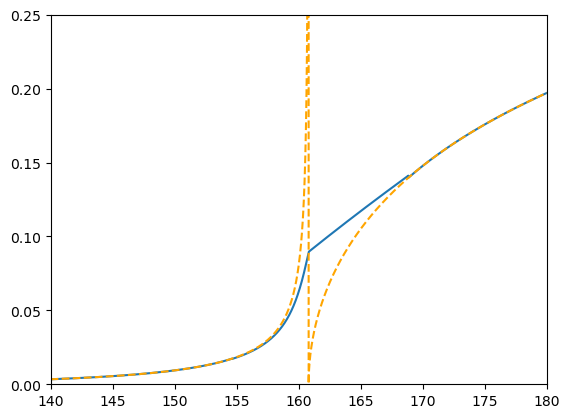

In [10]:
def Gamma_WW(mS, WW_approx=False):
    # DO NOT use "WW_approx", flag is present only for testing purposes
    
    m_tb = 172.57 + 4.2  # GeV
    
    Gamma = np.zeros_like(mS)
    
    # On-shell decay region
    on_shell_mask = mS >= 2*MW
    
    x_W = 4 * MW**2 / (mS[on_shell_mask]**2)
    
    Gamma_OS = mH**3 / vH**2 / (16 * np.pi) * np.sqrt(1-x_W) * (1 - x_W + 0.75 * x_W**2)
    Gamma[on_shell_mask] = Gamma_OS
    
    # Off-shell decay region
    off_shell_mask = np.logical_and(mS < 2*MW, mS >= MW)
    x_OS = MW / mS[off_shell_mask]
    
    f_W = np.ones_like(mS[off_shell_mask]) * 3.0
    # Factor increases to 4 if W* --> tb is open
    # Minimum energy must be mS >= mW + mt + mb
    tb_threshold = MW + m_tb
    f_W[mS[off_shell_mask] > tb_threshold] = 4.0

    if WW_approx:
        Gamma[off_shell_mask] = MW**4 / (32 * np.pi**3 * vH**4) * mH * f_WW_star_approx(x_OS) * f_W
    else:
        Gamma[off_shell_mask] = MW**4 / (32 * np.pi**3 * vH**4) * mH * f_WW_star_corrected(x_OS) * f_W
        
        # On-shell formula is at zero W width; patch together with linear interpolation
        transition_mask = np.logical_and(mS >= 2*MW, mS <= 2.1*MW)
        x_T = MW / mS[transition_mask]

        x0 = 0.5
        x1 = 0.47

        x1_W = 4 * x1**2
        y0 = MW**4 / (32 * np.pi**3 * vH**4) * mH * f_WW_star_corrected(x0) * 3
        y1 = mH**3 / vH**2 / (16 * np.pi) * np.sqrt(1-x1_W) * (1 - x1_W + 0.75 * x1_W**2)

        Gamma_int = np.interp(x_T, np.array([x1, x0]), np.array([y1, y0]))
        Gamma[transition_mask] = Gamma_int
    
    return Gamma


mS_range = np.linspace(80, 200, 50000)
plt.plot(mS_range, Gamma_WW(mS_range))
plt.plot(mS_range, Gamma_WW(mS_range, WW_approx=True), ls='--', color='orange')
plt.ylim(0,0.25)
plt.xlim(140,180)
plt.show()

In [11]:
def Gamma_SM_Higgs(mS):
    base_gamma = 1 / (8 * np.pi * vH**2)
    
    gamma = 0.0
    for F in SM_masses.keys():
        mF = SM_masses[F]
        th_mask = 2*SM_masses[F] < mS
        
        gamma_F = base_gamma * mF**2 * mS
        gamma_F *= SM_Nc[F]
        
        gamma_F[th_mask] *= (1 - 4*mF**2 / mS[th_mask]**2)**(3/2)
        gamma_F[~th_mask] *= 0
        
        gamma += gamma_F
        
    gamma += Gamma_WW(mS)
                
    return gamma

def Gamma_glueball(theta, M_Bd, r_Bd_eta=0.5, HQ=False, ND=4):
    M_G, F_G = glueball_mass_F(M_Bd, r_Bd_eta=r_Bd_eta, HQ=HQ, ND=ND)
    
    # Factoring out F_G which is computed separately
    base_gamma = (4) / (9*np.pi**2)
    base_gamma *= theta**4
    base_gamma *= F_G**2
    base_gamma /= vH**2 * (mH**2 - M_G**2)**2
    
#    base_gamma = (3.1)**2 / (9 * np.pi**4)
#    base_gamma *= (ND / 3)**2
#    base_gamma *= theta**4
#    base_gamma *= M_G**6 / (vH**2 * (mH**2 - M_G**2)**2)

    
    return base_gamma * Gamma_SM_Higgs(M_G)


def ctau_glueball(theta, M_Bd, r_Bd_eta=0.5, ND=4, HQ=False):
    gamma = Gamma_glueball(theta, M_Bd, r_Bd_eta=r_Bd_eta, ND=ND, HQ=HQ)
    
    ctau = 1/gamma * GeV_to_s
    
    return ctau

In [12]:
# Check: SM Higgs decay width.
# This is only including bb (and other sub-leading fermion decays);
# should be about 70% of the SM Higgs width, the other 30% is in WW.
# SM prediction is about 4 MeV.
print("Predicted Higgs decay: ", 1000*Gamma_SM_Higgs(np.array([mH])), "MeV")

# This is probably close enough for just using the simplest tree-level formula!

Predicted Higgs decay:  [5.74180112] MeV


(0.01, 10.0)

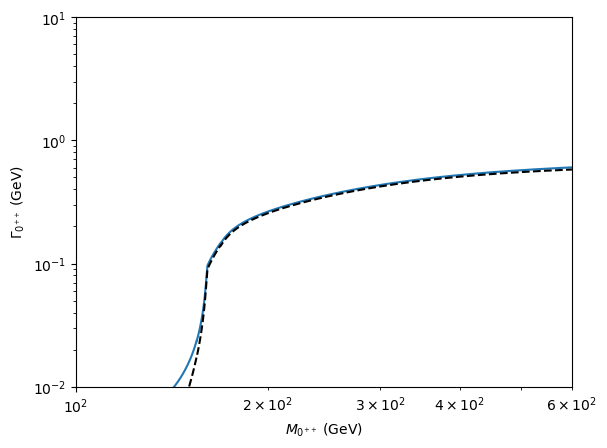

In [13]:
mx = np.linspace(5e-3,1000,20000)
G_0 = Gamma_SM_Higgs(mx)
G_WW = Gamma_WW(mx)

plt.plot(mx, G_0)
plt.plot(mx, G_WW, color='k', ls='--')
plt.yscale('log')
plt.xscale('log')

plt.xlabel("$M_{0^{++}}$ (GeV)")
plt.ylabel("$\\Gamma_{0^{++}}$ (GeV)")
plt.xlim(100,600)
plt.ylim(1e-2,1e1)

Text(0, 0.5, '$\\Gamma_{0^{++}}$ (GeV)')

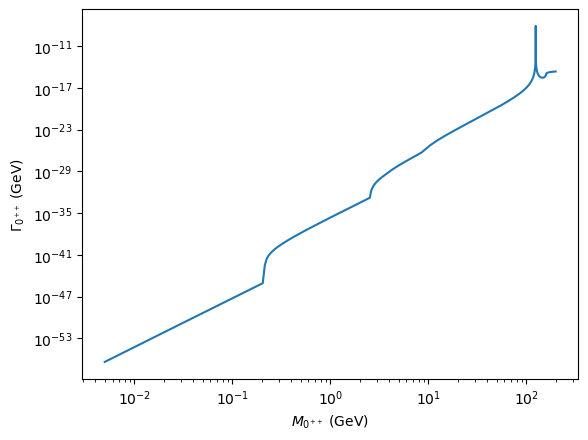

In [14]:
mx = np.linspace(5e-3,200,20000)
G_0 = Gamma_glueball(1e-3, mx, HQ=False)

plt.plot(mx, G_0)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("$M_{0^{++}}$ (GeV)")
plt.ylabel("$\\Gamma_{0^{++}}$ (GeV)")

Skipping hadronic branching here since I wasn't using it below - will fix if needed.  Thresholds are identical to those for the $\eta'_d$.

### $\sigma$ meson decay

Finally, we come to the $\sigma$ meson.  The partial decay formula is

$$
\Gamma_{\sigma \rightarrow \xi \xi} = 4 \theta^4 \left( \frac{m_{\rm eq}}{v} \right)^2 \left( \frac{F_\sigma}{m_h^2 - m_\sigma^2} \right)^2 \Gamma^{\rm SM}_{h \rightarrow \xi \xi}(m_\sigma^2).
$$

This is similar to what is done above - I'll recycle the Higgs partial decay width results in particular.  This requires an additional input, $m_{\rm eq}$, also known as the EFT cutoff scale $\Lambda$.


In [15]:
def Gamma_sigma(theta, M_Bd, m_eq, chi_sigma=1.0, ND=ND_default):
    mS, FS = sigma_mass_F(M_Bd, chi_sigma=chi_sigma, ND=ND)
    
    base_gamma = 4 * theta**4
    base_gamma *= (m_eq / vH)**2
    base_gamma *= (FS / (mH**2 - mS**2))**2
    
    return base_gamma * Gamma_SM_Higgs(mS)
    

Text(0, 0.5, '$\\Gamma_{0^{++}}$ (GeV)')

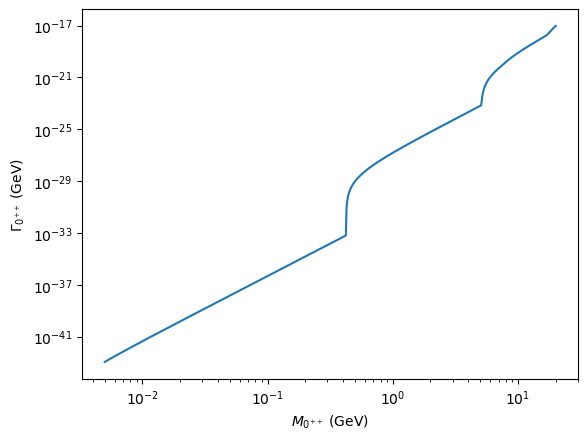

In [16]:
mx = np.linspace(5e-3,20,20000)
G_S = Gamma_sigma(1e-3, mx, m_eq=5000)

plt.plot(mx, G_S)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("$M_{0^{++}}$ (GeV)")
plt.ylabel("$\\Gamma_{0^{++}}$ (GeV)")

## First bound: direct detection/Z-exchange

See paper for the updated formulas.  First, order-of-magnitude estimates which appear in the paper.

In [17]:
GF = 1.1664e-5  # GeV^{-2}, from PDG
sin2_w = 0.23121  # PDG
m_nuc = 0.939  # GeV, approximate mass of a nucleon
Z_Xe = 54   # Xe
A_Xe = 130  # Xe, approximate isotopic average
Z_Ar = 18   # Ar, for DS-50
A_Ar = 40   # Only abundant stable isotope
GeVm2_to_cm2 = 1/(5.06e13)**2  # GeV^{-2} to cm^{2}


def mu_red(M_DM, M_N=130):
    return (M_DM * M_N) / (M_DM + M_N)

## Order of magnitude estimation - Z
sigma_approx_factor = (A_Xe - Z_Xe)**2 * 4**2 * GF**2 / (2 * np.pi) * 246**2 / (4 * 90**2) / A_Xe**2
sigma_approx_factor *= GeVm2_to_cm2
print(sigma_approx_factor)

8.637733219244339e-38


In [18]:
## Higgs parameters
sigma_pi_N = 0.0649  # GeV, from FLAG
sigma_s = 0.041      # GeV, from FLAG

f_ud = sigma_pi_N / m_nuc
f_s = sigma_s / m_nuc
print("f_ud: ", f_ud, "f_s: ", f_s)

g_N = (m_nuc / vH) * (f_ud + f_s + 6/27 * (1 - f_ud - f_s))
print(g_N, g_N * vH / m_nuc, 6/27)

mH = 125  # GeV

## Dark sector coupling
g_BD = ((5000 / (1/4))) * (1 / vH)

## Higgs estimation
sigma_approx_H = 1 / (np.pi) / (mH)**4 * g_N**2 * g_BD**2
sigma_approx_H /= (5.06e13)**2
print(sigma_approx_H)


## Simple cross-section: assuming th^2 L = m_n.
g_BD_simple = 1 / vH
sigma_simple_H = 1 / (np.pi) / (mH)**4 * g_N**2 * g_BD_simple**2
sigma_simple_H /= (5.06e13)**2
print(sigma_simple_H)

f_ud:  0.0691160809371672 f_s:  0.043663471778487756
0.0011830623306233064 0.3099396521121761 0.2222222222222222
4.711010492460052e-39
1.1777526231150128e-47


In [19]:
def sigma_Z_LZ(theta, M_Bd, ND=4, eps=0.9):
    mu = mu_red(M_Bd)
    
    sig = mu**2 * GF**2 / (2*np.pi)
    
    AZ_factor = ((1 - 4 * sin2_w) * Z_Xe - (A_Xe-Z_Xe))
    
    sig *= AZ_factor**2
    
    sig *= vH**2 / (4*MZ**2)
    
    sig *= ND**2
    sig *= theta**4
    sig *= (1 + eps**2)**2
    
    #sig /= 16
    
    # Convert to PER NUCLEON CROSS SECTION!  Ref: M. Lisanti, 1603.03797
    mu_nucleon = mu_red(M_Bd, M_N=m_nuc)
    sig *= (mu_nucleon /  mu)**2
    sig /= A_Xe**2
    
    # Convert from GeV^{-2} to cm^{2}
    sig *= GeVm2_to_cm2
    
    return sig

def sigma_Z_DS50(theta, M_Bd, ND=4, eps=0.9):
    mu = mu_red(M_Bd, M_N=38)
    
    sig = mu**2 * GF**2 / (2*np.pi)
    
    AZ_factor = ((1 - 4 * sin2_w) * Z_Ar - (A_Ar-Z_Ar))
    
    sig *= AZ_factor**2
    
    sig *= vH**2 / (4*MZ**2)
    
    sig *= ND**2
    sig *= theta**4
    sig *= (1+eps**2)**2
    
    #sig /= 16
    
    # Convert to PER NUCLEON CROSS SECTION!  Ref: M. Lisanti, 1603.03797
    mu_nucleon = mu_red(M_Bd, M_N=m_nuc)
    sig *= (mu_nucleon /  mu)**2
    sig /= A_Ar**2
    
    # Convert from GeV^{-2} to cm^{2}
    sig *= GeVm2_to_cm2
    
    return sig

def sigma_Z_approx(theta, M_Bd):
    return 1e-37 * theta**4 * mu_red(M_Bd, M_N=m_nuc)**2


def sigma_H(theta, M_Bd, ND=4, m_eq=m_eq_default, heavy_quark=True):
    mu_nucleon = mu_red(M_Bd, M_N=m_nuc)
    if heavy_quark:
        m_n = M_Bd / ND  # heavy-quark limit
        f_n_Bd = 0.5       # DeGrand and Neil, heavy-quark regime
    else:
        m_n = M_Bd / ND / 17  # light-quark limit
        f_n_Bd = 0.05      # DeGrand and Neil, x = 0.1 
    
    f_ud = sigma_pi_N / m_nuc
    f_s = sigma_s / m_nuc
    
    g_N = (m_nuc / vH) * (f_ud + f_s + 6/27 * (1 - f_ud - f_s))
    g_BD = (m_eq / m_n) * (M_Bd / vH) * theta**2 * f_n_Bd
    
    sig = (g_N * g_BD / mH**2)**2 
    sig *= mu_nucleon**2 / np.pi
    
    # GeV^{-2} to cm^{2}
    sig *= GeVm2_to_cm2
    
    return sig


Import digitized bounds from the LZ experiment:

In [20]:
LZ_bound_file = 'LZ_Fig5_SpinIndependentLimitandSensitivity.txt'  # 2207.03764
LZ_bound_light = 'LZ_SR1_Limit_WimpMigdal_SI.txt'  # 2307.15753

LZ_raw_data = np.genfromtxt(LZ_bound_file)[1:,:]
LZ_raw_light = np.genfromtxt(LZ_bound_light)[0:,:]  # Line 0 is auto-skipped here due to the # mark...

LZ_med_vs_m = LZ_raw_data[:,[0,1]]
LZ_med_vs_m_light = LZ_raw_light[:,[0,2]]

print(LZ_med_vs_m[0:3])

print(LZ_med_vs_m_light[0:3])

# Combine limits

LZ_joint = np.concatenate([LZ_med_vs_m_light, LZ_med_vs_m])

[[9.00000e+00 3.88141e-46]
 [1.10000e+01 1.05545e-46]
 [1.30000e+01 4.19377e-47]]
[[5.00000e-01 7.65821e-38]
 [6.00000e-01 2.22331e-38]
 [7.00000e-01 9.92004e-39]]


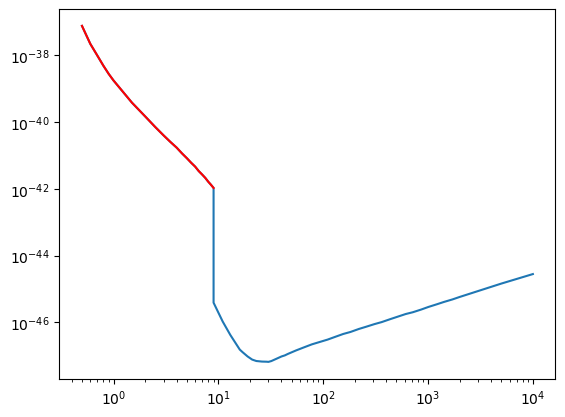

In [21]:
plt.plot(LZ_joint[:,0], LZ_joint[:,1])
plt.plot(LZ_med_vs_m_light[:,0], LZ_med_vs_m_light[:,1], color='red')

plt.xscale('log')
plt.yscale('log')

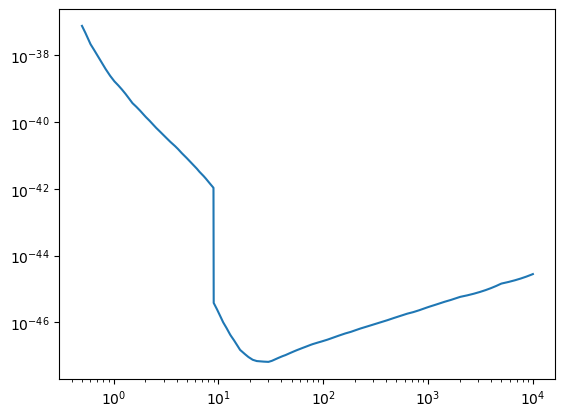

In [22]:
## Interpolation of LZ results, for solving below
mx = np.exp(np.linspace(np.log(0.5), np.log(1e4), 2000))
LZ_interp = np.exp(np.interp(mx, LZ_joint[:,0], np.log(LZ_joint[:,1])))

plt.plot(mx, LZ_interp)
plt.xscale('log')
plt.yscale('log')

Next, DarkSide-50.  They don't seem to release their actual data, so I have to guess at it from their plot, which is annoying...

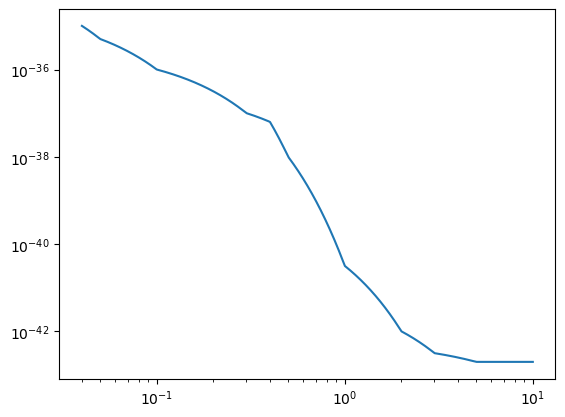

In [23]:
log_DS50_points = np.array([
    [0.04, -35],
    [0.05, -35.3],
    [0.1, -36],
    [0.3, -37],
    [0.4, -37.2],
    [0.5, -38],
    [1, -40.5],
    [2, -42],
    [3, -42.5],
    [4, -42.6],
    [5, -42.7],
    [10, -42.7],
])

m50 = np.exp(np.linspace(np.log(0.04), np.log(10), 2000))

DS50_interp = 10**(np.interp(m50, log_DS50_points[:,0], log_DS50_points[:,1]))

plt.plot(m50, DS50_interp)
plt.xscale('log')
plt.yscale('log')

Import the neutrino floor, taken from [Ciaran O'Hare on GitHub](https://github.com/cajohare/NeutrinoFog), file "Xe_SI"

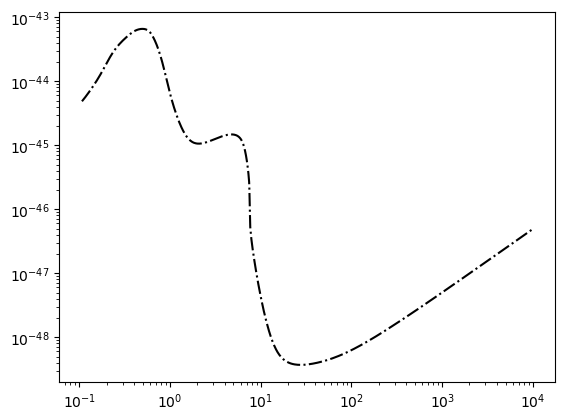

In [24]:
NF_file = "Xe_SI.txt"
NF_raw_data = np.genfromtxt(NF_file)[3:,:]

mx_nu = np.exp(np.linspace(np.log(NF_raw_data[0,0]), np.log(NF_raw_data[-1,0]), 2000))
NF_interp = np.exp(np.interp(mx_nu, NF_raw_data[:,0], np.log(NF_raw_data[:,1])))

#plt.plot(mx, NF_interp, color='k', ls='-.')

plt.plot(mx_nu, NF_interp, color='k', ls='-.')

plt.xscale('log')
plt.yscale('log')

In [25]:
def compute_LZ_bound(M_Bd, ND=ND_default, NF=False, m_eq=m_eq_default, heavy_quark=True, 
                     Higgs_only=False, Z_only=False):

    mx = np.exp(np.linspace(np.log(LZ_joint[0,0]), np.log(LZ_joint[-1,0]), 5000))
    LZ_interp = np.exp(np.interp(mx, LZ_joint[:,0], np.log(LZ_joint[:,1])))
    
    mass_i = np.argmin(np.abs(mx - M_Bd))
    LZ_bound = LZ_interp[mass_i]
    if NF:
        # Rough mock-up of neutrino floor location; 1e-3 below LZ bound
        LZ_bound *= 1e-3
    
    def cost_f(theta):
        if Z_only:
            sig = sigma_Z_LZ(theta, M_Bd, ND=ND)
        else:
            sig = sigma_H(theta, M_Bd, m_eq=m_eq, heavy_quark=heavy_quark)        
            if not Higgs_only:
                sig += sigma_Z_LZ(theta, M_Bd, ND=ND)

        ldiff = np.log(sig) - np.log(LZ_bound)
        return ldiff
            
    return newton(cost_f, 1e-5)

def compute_NF_bound(M_Bd, ND=ND_default, m_eq=m_eq_default, heavy_quark=True,
                     Higgs_only=False, Z_only=False):

    mx_nu = np.exp(np.linspace(np.log(NF_raw_data[0,0]), np.log(NF_raw_data[-1,0]), 2000))
    NF_interp = np.exp(np.interp(mx_nu, NF_raw_data[:,0], np.log(NF_raw_data[:,1])))
    
    mass_i = np.argmin(np.abs(mx_nu - M_Bd))
    NF_bound = NF_interp[mass_i]
    
    def cost_f(theta):
        if Z_only:
            sig = sigma_Z_LZ(theta, M_Bd, ND=ND)
        else:
            sig = sigma_H(theta, M_Bd, m_eq=m_eq, heavy_quark=heavy_quark)        
            if not Higgs_only:
                sig += sigma_Z_LZ(theta, M_Bd, ND=ND)

        ldiff = np.log(sig) - np.log(NF_bound)
        return ldiff
            
    return newton(cost_f, 1e-5)

m50 = np.exp(np.linspace(np.log(0.04), np.log(10), 5000))
DS50_interp = 10**(np.interp(m50, log_DS50_points[:,0], log_DS50_points[:,1]))

def compute_DS50_bound(M_Bd, ND=ND_default, heavy_quark=True, m_eq=m_eq_default, 
                       Higgs_only=False, Z_only=False):
    mass_i = np.argmin(np.abs(m50 - M_Bd))
    DS50_bound = DS50_interp[mass_i]
    
    # DS50 interpolation not present beyond 10 GeV; return "infinite" bound
    # beyond that
    if M_Bd > 10:
        return np.inf

    def cost_f(theta):
        if Z_only:
            sig = sigma_Z_DS50(theta, M_Bd, ND=ND)
        else:
            sig = sigma_H(theta, M_Bd, m_eq=m_eq, heavy_quark=heavy_quark)
            if not Higgs_only:
                sig += sigma_Z_DS50(theta, M_Bd, ND=ND)
            
        ldiff = np.log(sig) - np.log(DS50_bound)
        return ldiff
    
    return newton(cost_f, 1e-5)


Finally, we can work backwards and convert this to a bound in the EFT by using the definition of the Z coupling,

$$
c_Z = \frac{\theta^2}{2M_Z^2},
$$

neglecting the Higgs coupling:



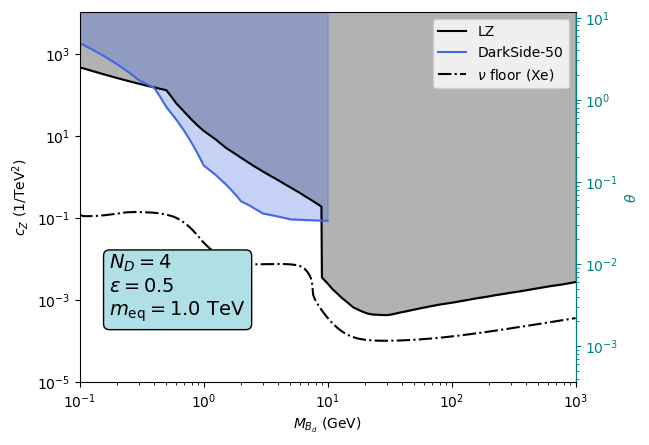

In [26]:
ND=4
m_eq=1000
eps=0.5

mx = np.logspace(-1, 3, 1000)
LZB_noH = []
for M_Bd in mx:
    LZB_noH.append(compute_LZ_bound(M_Bd, ND=ND, Z_only=True))
    
LZB_noH = np.asarray(LZB_noH)

mx2 = np.logspace(-2, 2, 1000)
DSB_noH = []
for M_Bd in mx2:
    DSB_noH.append(compute_DS50_bound(M_Bd, ND=ND, Z_only=True))

DSB_noH = np.asarray(DSB_noH)

mx_nu = np.logspace(-2, 3, 2000)
NFB_noH = []
for M_Bd in mx_nu:
    NFB_noH.append(compute_NF_bound(M_Bd, ND=ND, Z_only=True))
NFB_noH = np.asarray(NFB_noH)

def theta_to_cZ(theta):
    return theta**2 * (1+eps**2) / (2*MZ**2) * m_eq**2

def cZ_to_theta(cZ):
#    return np.sqrt(2*MZ**2*cZ)
    return np.sqrt(2*MZ**2*cZ/m_eq**2/(1+eps**2))

plt.plot(mx, theta_to_cZ(LZB_noH), color='k', label='LZ')
plt.plot(mx2, theta_to_cZ(DSB_noH), color='royalblue', label='DarkSide-50')
plt.plot(mx_nu, theta_to_cZ(NFB_noH), color='k', ls='-.', label='$\\nu$ floor (Xe)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d}\\ ({\\rm GeV})$')
#plt.ylabel('$\\theta$')
plt.ylabel('$c_Z\\ (1/{\\rm TeV}^2)$')

plt.ylim(1e-5,1e4)
plt.xlim(1e-1,1e3)

plt.legend()

ax = plt.gca()
ax.fill_between(mx, theta_to_cZ(LZB_noH), 1e6, color='k', alpha=0.3)
ax.fill_between(mx2, theta_to_cZ(DSB_noH), 1e6, color='royalblue', alpha=0.3)

# Label model params used
info_str = '\n'.join([
    f'$N_D = {ND}$',
    f'$\\epsilon = {eps}$',
    '$m_{\\rm eq} = ' + f'{m_eq/1000}$ TeV',
])

ax.text(0.06, 0.18, info_str, transform=ax.transAxes, fontsize=14, 
        bbox={'boxstyle': 'round', 'facecolor': 'powderblue'})

ax2 = ax.secondary_yaxis('right', functions=(cZ_to_theta, theta_to_cZ))
#ax2.set_ylabel("$c_Z / \Lambda^2 ({\\rm GeV}^{-2})$")
ax2.set_ylabel("$\\theta$")
alt_ax_color='teal'
ax2.tick_params(axis='y', which='both', colors=alt_ax_color)
ax2.yaxis.label.set_color(alt_ax_color)
ax.spines['right'].set_color(alt_ax_color)

if save_plots:
    plt.savefig('DD_bounds.pdf', bbox_inches='tight')


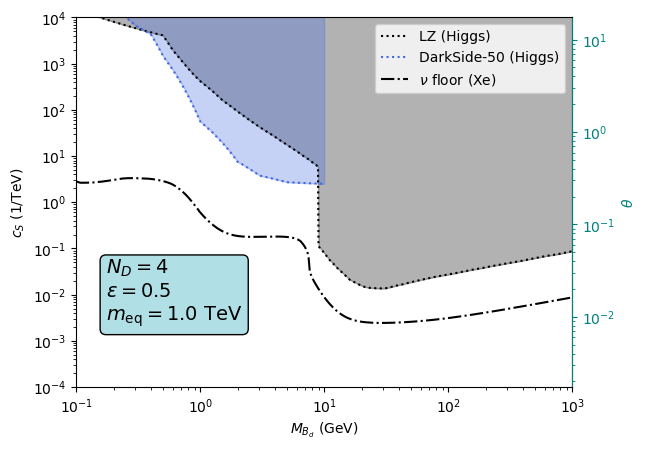

In [27]:
ND=4
m_eq=1000
eps=0.5

mx = np.logspace(-1, 3, 1000)
LZB_noZ = []
for M_Bd in mx:
    LZB_noZ.append(compute_LZ_bound(M_Bd, ND=ND, m_eq=m_eq, Higgs_only=True))
    
LZB_noZ = np.asarray(LZB_noZ)

mx2 = np.logspace(-2, 2, 1000)
DSB_noZ = []
for M_Bd in mx2:
    DSB_noZ.append(compute_DS50_bound(M_Bd, ND=ND, m_eq=m_eq, Higgs_only=True))

DSB_noZ = np.asarray(DSB_noZ)

mx_nu = np.logspace(-2, 3, 2000)
NFB_noZ = []
for M_Bd in mx_nu:
    NFB_noZ.append(compute_NF_bound(M_Bd, ND=ND, Higgs_only=True))
NFB_noZ = np.asarray(NFB_noZ)

def theta_to_cS(theta):
    return 2*theta**2 * m_eq**2 / (vH**2)

def cS_to_theta(cS):
    return np.sqrt(cS * vH**2 / m_eq**2 / 2)

plt.plot(mx, theta_to_cS(LZB_noZ), color='k', label='LZ (Higgs)', ls=':')
plt.plot(mx2, theta_to_cS(DSB_noZ), color='royalblue', label='DarkSide-50 (Higgs)', ls=':')
plt.plot(mx_nu, theta_to_cZ(NFB_noZ), color='k', ls='-.', label='$\\nu$ floor (Xe)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d}\\ ({\\rm GeV})$')
#plt.ylabel('$\\theta$')
plt.ylabel('$c_S\\ (1/{\\rm TeV})$')

plt.ylim(1e-4,1e4)
plt.xlim(1e-1,1e3)

plt.legend()

ax = plt.gca()
ax.fill_between(mx, theta_to_cS(LZB_noZ), 1e6, color='k', alpha=0.3)
ax.fill_between(mx2, theta_to_cS(DSB_noZ), 1e6, color='royalblue', alpha=0.3)

# Label model params used
info_str = '\n'.join([
    f'$N_D = {ND}$',
    f'$\\epsilon = {eps}$',
    '$m_{\\rm eq} = ' + f'{m_eq/1000}$ TeV',
])

ax.text(0.06, 0.18, info_str, transform=ax.transAxes, fontsize=14, 
        bbox={'boxstyle': 'round', 'facecolor': 'powderblue'})

ax2 = ax.secondary_yaxis('right', functions=(cS_to_theta, theta_to_cS))
ax2.set_ylabel("$\\theta$")
alt_ax_color='teal'
ax2.tick_params(axis='y', which='both', colors=alt_ax_color)
ax2.yaxis.label.set_color(alt_ax_color)
ax.spines['right'].set_color(alt_ax_color)

if save_plots:
    plt.savefig('DD_bounds_Higgs.pdf', bbox_inches='tight')


## Second bound: BBN for eta' and other mesons

Our BBN bounds follow from [hep-ph/0604251](http://arxiv.org/abs/hep-ph/0604251).  The rough idea, following the [large N-ightmare paper](http://arxiv.org/abs/2010.03586), is that we expect to greatly overproduce $\eta'$ mesons in the early universe - of course, we don't entirely trust their way of estimating this for our model, but the conservative thing is to assume it will happen.

If $\Omega_{\eta'} h^2$ is large, $\gtrsim 10^0$, then if the hadronic branching $B_h \sim 1$ the bound is roughly $\tau_{\eta'} < 0.1$ s.  On the other hand, if $B_h = 0$ the bound weakens to $\tau_{\eta'} < 10^4$ s.  It is likely that there is an intermediate region for $m_{\eta'}$ around 1 GeV for which $B_h$ is small but not zero, in which case the bound would be $\tau_{\eta'} < 10^2$ s.  But I will focus on the two extreme cases to bound things.

From above, we know that $B_h \sim 1$ for $m_{\eta'} \gtrsim 2.5$ GeV.  I'll consider the stronger bound down to 0.5 GeV, and the weaker bound up to 3 GeV:

In [28]:
# Hadronic/EM decay region limits, from paper
edge_EM_eta = 1.0     # GeV
edge_EM_scalar = 0.5  # GeV
edge_HAD = 3.0        # GeV, same for all states


def compute_BBN_bound(M_Bd, Gamma_func, tau_max=0.1, **kwargs):
    
    def cost(ln_th):
        theta = np.exp(ln_th)
        Gam = Gamma_func(theta, np.array([M_Bd]), **kwargs)
        
        tau = 1/Gam * GeV_to_s
        
        return np.log(tau) - np.log(tau_max)
    
    ln_th_opt = newton(cost, np.log(1e-3), maxiter=1000, rtol=1e-3)[0]

    return np.exp(ln_th_opt)

In [29]:
def plot_BBN_bound(Gamma_func, meson_mass_func, log_mx_min=-2, log_mx_max=np.log10(300), color_l='orange', 
                   color_h='goldenrod', edge_EM=edge_EM_eta, edge_HAD=edge_HAD, label=None, map_func=None, ls=None, 
                   ls_tail='--', plot_vs_meson_mass=False, **kwargs):
        
    mx = np.logspace(log_mx_min, log_mx_max, 1000)
    BBNB_heavy = []  # BH ~ 1
    BBNB_light = []  # BH ~ 0
    
    m_meson, _ = meson_mass_func(mx, **kwargs)
    
    if plot_vs_meson_mass:
        m_plot = m_meson
    else:
        m_plot = mx
    
    for M_Bd in mx:
        BBNB_heavy.append(compute_BBN_bound(M_Bd, Gamma_func, **kwargs))
        BBNB_light.append(compute_BBN_bound(M_Bd, Gamma_func, tau_max = 1e4, **kwargs))

    BBNB_heavy, BBNB_light = np.asarray(BBNB_heavy), np.asarray(BBNB_light)

    light_region = m_meson <= edge_EM
    light_tail = np.logical_and(m_meson >= edge_EM, m_meson <= edge_HAD)

    heavy_region = m_meson >= edge_HAD
    heavy_tail = np.logical_and(m_meson >= edge_EM, m_meson <= edge_HAD)

    if map_func is not None:
        plt.plot(m_plot[light_region], map_func(BBNB_light[light_region]), color=color_l, label=label, ls=ls)
        plt.plot(m_plot[light_tail], map_func(BBNB_light[light_tail]), color=color_l, ls=ls_tail)

        plt.plot(m_plot[heavy_region], map_func(BBNB_heavy[heavy_region]), color=color_h, ls=ls)
        plt.plot(m_plot[heavy_tail], map_func(BBNB_heavy[heavy_tail]), color=color_h, ls=ls_tail)

    else:
        plt.plot(m_plot[light_region], BBNB_light[light_region], color=color_l, label=label, ls=ls)
        plt.plot(m_plot[light_tail], BBNB_light[light_tail], color=color_l, ls=ls_tail)

        plt.plot(m_plot[heavy_region], BBNB_heavy[heavy_region], color=color_h, ls=ls)
        plt.plot(m_plot[heavy_tail], BBNB_heavy[heavy_tail], color=color_h, ls=ls_tail)

    return (BBNB_heavy, BBNB_light, mx, m_meson)




(0.1, 300.0)

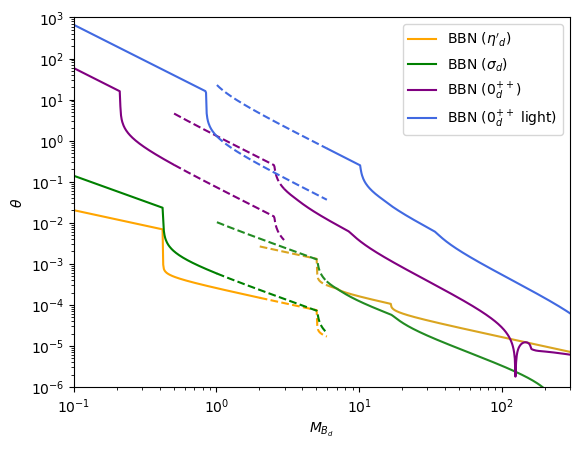

In [30]:
plot_BBN_bound(Gamma_eta_prime, eta_mass_F, label="BBN ($\\eta'_d$)", ND=4, r_Bd_eta=0.5)
#plot_BBN_bound(Gamma_eta_prime, label="BBN ($\\eta'$)", ND=4, r_Bd_eta=0.33, ls=':', ls_tail=':')
#plot_BBN_bound(Gamma_eta_prime, label="BBN ($\\eta'$)", ND=4, r_Bd_eta=0.67, ls='-.', ls_tail='-.')

plot_BBN_bound(Gamma_sigma, sigma_mass_F, color_l='green', color_h='forestgreen', label="BBN ($\\sigma_d$)", 
               edge_EM=edge_EM_scalar, m_eq=3000, ND=4)
plot_BBN_bound(Gamma_glueball, glueball_mass_F, color_l='purple', color_h='purple', label="BBN ($0^{++}_d$)", 
               edge_EM=edge_EM_scalar, HQ=False, ND=4)
plot_BBN_bound(Gamma_glueball, eta_mass_F, color_l='royalblue', color_h='royalblue', label="BBN ($0^{++}_d$ light)",
               edge_EM=edge_EM_scalar, HQ=True, ND=4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d}$')
plt.ylabel('$\\theta$')
plt.legend()

plt.ylim(1e-6,1e3)
plt.xlim(1e-1,3e2)

Now, publication versions of the above plots.

In [31]:
# Settings for plots below
ND=4
eps=0.5
m_eq=1000
#r_Bd_eta=0.5
#heavy_glue=True

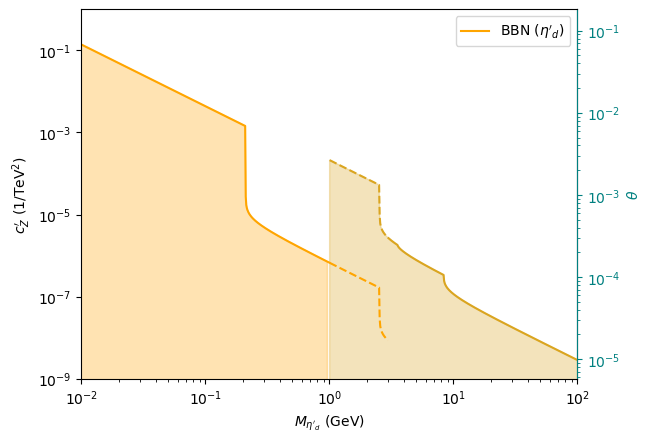

In [32]:
def theta_to_cZp(theta):
    return theta**2 * eps**2 / MZ**2 * m_eq**2

def cZp_to_theta(cZp):
    return np.sqrt(cZp * MZ**2 / eps**2 / m_eq**2)

Bh, Bl, mx, m_eta = plot_BBN_bound(Gamma_eta_prime, eta_mass_F, label="BBN ($\\eta'_d$)", map_func=theta_to_cZp, 
                            r_Bd_eta=0.5, ND=ND, eps=eps, plot_vs_meson_mass=True)
#Bh_l, Bl_l, mx, m_eta_L = plot_BBN_bound(Gamma_eta_prime, eta_mass_F, label="BBN ($\\eta'_d$ light)", map_func=theta_to_cZp, 
#                            r_Bd_eta=0.33, ls='-.', ls_tail='-.', ND=ND, plot_vs_meson_mass=True)
#Bh_h, Bl_h, mx, m_eta_H = plot_BBN_bound(Gamma_eta_prime, eta_mass_F, label="BBN ($\\eta'_d$ heavy)", map_func=theta_to_cZp, 
#                            r_Bd_eta=0.67, ls=':', ls_tail=':', ND=ND, plot_vs_meson_mass=True)

plt.xscale('log')
plt.yscale('log')
#plt.xlabel('$M_{B_d}$')
plt.xlabel("$M_{\\eta'_d}\\ ({\\rm GeV})$")
plt.ylabel("$c_Z'\\ (1/{\\rm TeV}^2)$")

ax = plt.gca()
#ax.fill_between(mx[mx>m_EM_L], theta_to_cZp(Bh_l[mx>m_EM_L]), color='goldenrod', alpha=0.3)
ax.fill_between(m_eta[m_eta>edge_EM_eta], theta_to_cZp(Bh[m_eta>edge_EM_eta]), color='goldenrod', alpha=0.3)
#ax.fill_between(mx[mx>m_EM_H], theta_to_cZp(Bh_h[mx>m_EM_H]), color='goldenrod', alpha=0.3)
ax.fill_between(m_eta[m_eta<0.975*edge_EM_eta], theta_to_cZp(Bl[m_eta<0.975*edge_EM_eta]), color='orange', alpha=0.3)


ax2 = ax.secondary_yaxis('right', functions=(cZp_to_theta, theta_to_cZp))
ax2.set_ylabel("$\\theta$")
alt_ax_color='teal'
ax2.tick_params(axis='y', which='both', colors=alt_ax_color)
ax2.yaxis.label.set_color(alt_ax_color)
ax.spines['right'].set_color(alt_ax_color)

plt.xlim(1e-2,1e2)
plt.ylim(1e-9,1e0)

plt.legend()

if save_plots:
    plt.savefig('BBN_bounds_eta.pdf', bbox_inches='tight')


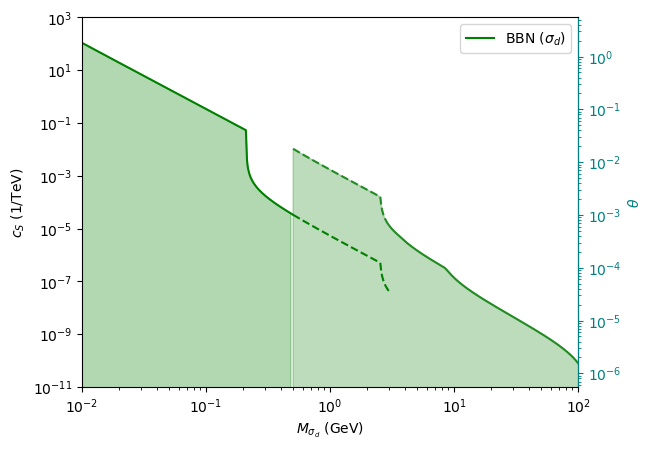

In [33]:

Bh, Bl, mx, m_sigma = plot_BBN_bound(Gamma_sigma, sigma_mass_F, label="BBN ($\\sigma_d$)", color_l='green', 
                                     color_h='forestgreen', edge_EM=edge_EM_scalar, 
                                     map_func=theta_to_cS, ND=ND, m_eq=m_eq,
                                     plot_vs_meson_mass=True)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{\\sigma_d}\\ ({\\rm GeV})$')
plt.ylabel("$c_S\\ (1/{\\rm TeV})$")

ax = plt.gca()
ax.fill_between(m_sigma[m_sigma>edge_EM_scalar], theta_to_cS(Bh[m_sigma>edge_EM_scalar]), color='forestgreen', alpha=0.3)
ax.fill_between(m_sigma[m_sigma<edge_EM_scalar*0.975], theta_to_cS(Bl[m_sigma<edge_EM_scalar*0.975]), color='green', alpha=0.3)

plt.xlim(1e-2,1e2)
plt.ylim(1e-11,1e3)

ax2 = ax.secondary_yaxis('right', functions=(cS_to_theta, theta_to_cS))
ax2.set_ylabel("$\\theta$")
alt_ax_color='teal'
ax2.tick_params(axis='y', which='both', colors=alt_ax_color)
ax2.yaxis.label.set_color(alt_ax_color)
ax.spines['right'].set_color(alt_ax_color)

plt.legend()

if save_plots:
    plt.savefig('BBN_bounds_sigma.pdf', bbox_inches='tight')



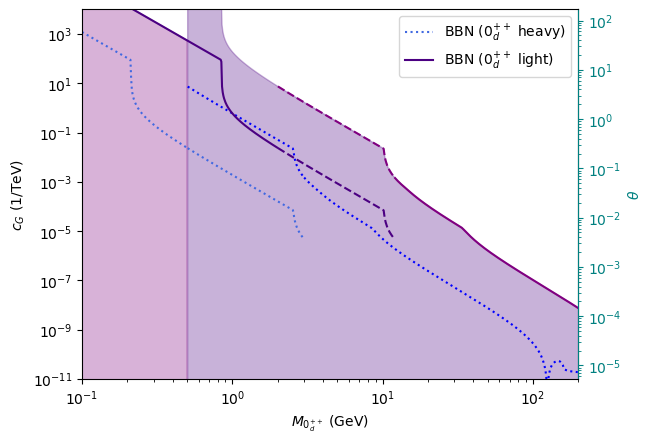

In [34]:
alpha_d = 0.1

def theta_to_cG(theta):
    return theta**2 * 2/(3*np.pi) * alpha_d * m_eq**2 / vH**2  

def cG_to_theta(cG):
    return np.sqrt(cG * (3*np.pi) / 2 / alpha_d * vH**2 / m_eq**2)


Bh_h, Bl_h, mx, m_G = plot_BBN_bound(Gamma_glueball, glueball_mass_F, label="BBN ($0^{++}_d$ heavy)", color_l='royalblue', color_h='blue',
                            edge_EM=edge_EM_scalar, map_func=theta_to_cG, 
                                     ls=':', ls_tail=':',
                                     ND=ND, HQ=False)
Bh_l, Bl_l, mx, m_G_L = plot_BBN_bound(Gamma_glueball, glueball_mass_F,
                                label="BBN ($0^{++}_d$ light)", color_l='indigo', color_h='purple',
                                edge_EM=edge_EM_scalar, 
                                map_func=theta_to_cG, ND=ND, HQ=True)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{0^{++}_d}\\ ({\\rm GeV})$')
plt.ylabel("$c_G\\ (1/{\\rm TeV})$")

ax = plt.gca()
ax.fill_between(m_G[m_G>edge_EM_scalar], theta_to_cG(Bh_l[m_G>edge_EM_scalar]), color='indigo', alpha=0.3)
ax.fill_between(m_G[m_G<edge_EM_scalar], theta_to_cG(Bl_l[m_G<edge_EM_scalar]), color='purple', alpha=0.3)

plt.xlim(1e-1,2e2)
plt.ylim(1e-11,1e4)

ax2 = ax.secondary_yaxis('right', functions=(cG_to_theta, theta_to_cG))
ax2.set_ylabel("$\\theta$")
alt_ax_color='teal'
ax2.tick_params(axis='y', which='both', colors=alt_ax_color)
ax2.yaxis.label.set_color(alt_ax_color)
ax.spines['right'].set_color(alt_ax_color)

plt.legend()

if save_plots:
    plt.savefig('BBN_bounds_glueball.pdf', bbox_inches='tight')

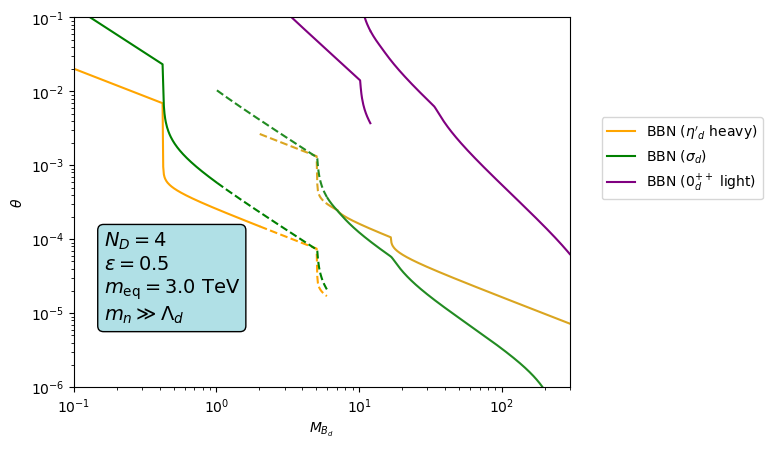

In [35]:
## Heavy-quark limit:
## Bd/eta = Bd/sigma = ND/2
## "light glue" (heavy_glue = False) - glueball is much lighter than other states.

m_eq = 3000

plot_BBN_bound(Gamma_eta_prime, eta_mass_F, label="BBN ($\\eta'_d$ heavy)", ND=ND, r_Bd_eta=0.5, HQ=True, 
               eps=eps)
plot_BBN_bound(Gamma_sigma, sigma_mass_F, color_l='green', color_h='forestgreen', label="BBN ($\\sigma_d$)", 
               edge_EM=edge_EM_scalar, m_eq=m_eq, ND=ND)
plot_BBN_bound(Gamma_glueball, glueball_mass_F, color_l='purple', color_h='purple', label="BBN ($0^{++}_d$ light)", 
               ls='-', ls_tail='-', edge_EM=edge_EM_scalar, HQ=True, ND=ND)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d}$')
plt.ylabel('$\\theta$')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,0.75))

ax = plt.gca()
# Label model params used
info_str = '\n'.join([
    f'$N_D = {ND}$',
    f'$\\epsilon = {eps}$',
    '$m_{\\rm eq} = ' + f'{m_eq/1000}$ TeV',
    '$m_n \\gg \\Lambda_d$'
])

ax.text(0.06, 0.18, info_str, transform=ax.transAxes, fontsize=14, 
        bbox={'boxstyle': 'round', 'facecolor': 'powderblue'})


plt.ylim(1e-6,1e-1)
plt.xlim(1e-1,3e2)

if save_plots:
    plt.savefig('BBN_bounds_HQ.pdf', bbox_inches='tight')

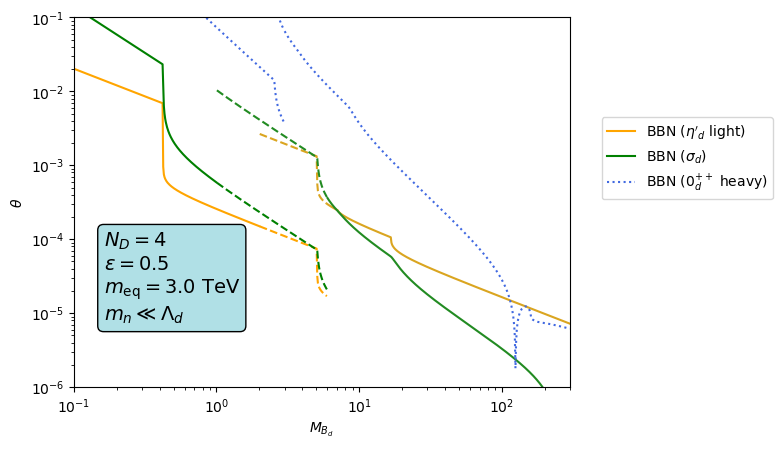

In [36]:
## Light-quark limit:
## Bd/eta = 2*ND/3  (larger ratio, eta lighter)
## "heavy glue" (heavy_glue = True) - glueball is comparable to other states.
## 0++ decay bound is irrelevant due to mixing effects

plot_BBN_bound(Gamma_eta_prime, eta_mass_F, label="BBN ($\\eta'_d$ light)", ND=ND, r_Bd_eta=0.5)
plot_BBN_bound(Gamma_sigma, sigma_mass_F, color_l='green', color_h='forestgreen', label="BBN ($\\sigma_d$)", 
               edge_EM=edge_EM_scalar, m_eq=m_eq, ND=ND)
plot_BBN_bound(Gamma_glueball, glueball_mass_F, color_l='royalblue', color_h='royalblue', label="BBN ($0^{++}_d$ heavy)",
               edge_EM=edge_EM_scalar, ls_tail=':', ls=':', HQ=False, ND=ND)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d}$')
plt.ylabel('$\\theta$')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,0.75))


ax = plt.gca()
# Label model params used
info_str = '\n'.join([
    f'$N_D = {ND}$',
    f'$\\epsilon = {eps}$',
    '$m_{\\rm eq} = ' + f'{m_eq/1000}$ TeV',
    '$m_n \\ll \\Lambda_d$'
])

ax.text(0.06, 0.18, info_str, transform=ax.transAxes, fontsize=14, 
        bbox={'boxstyle': 'round', 'facecolor': 'powderblue'})


plt.ylim(1e-6,1e-1)
plt.xlim(1e-1,3e2)

if save_plots:
    plt.savefig('BBN_bounds_LQ.pdf', bbox_inches='tight')

Before we move on, can we add contours of $\eta'$ lifetime to the bound plot?

In [37]:
## BBN decay length?
BBN_len = 1 * 2.99e8
BBN_len

299000000.0

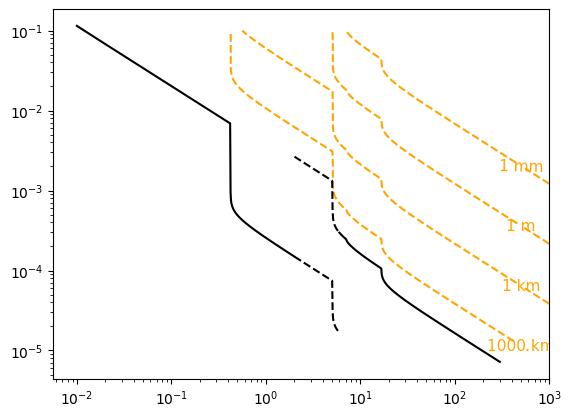

In [38]:
def draw_decay_lengths(mx, th, r_Bd_eta=0.5, eps=0.5, ND=4, check_BBN=False, HQ=False):
    M,T = np.meshgrid(mx, th, indexing='xy')
    
    if HQ:
        # HQ limit --> show glueball decay lengths instead
        decay_color='indigo'
        ctau = ctau_glueball(T, M, r_Bd_eta=r_Bd_eta, ND=ND, HQ=HQ)
    else:
        decay_color='orange'
        ctau = ctau_eta_prime(T, M, r_Bd_eta=r_Bd_eta, eps=eps, ND=ND)

    decay_len = ctau * 2.99e8

    #levels = [1e-2, 1e-1, 1, 1e1, 1e2, 1e4]
    #level_strs = ["0.01", "0.1", "1", "10", "100", "10,000"]

    if check_BBN:
        levels = [1e-6, 1e-3, 1, 1000, 2.99e7, 2.99e12]
        level_strs = ["1 μm", "1 mm", "1 m", "1 km", "1 ls", "1e4 ls"]
    else:
        levels = [1e-3, 1, 1000, 1000000]
        level_strs = ["1 mm", "1 m", "1 km", "1000 km"]
    cfmt = {}
    for l, s in zip(levels, level_strs):
        cfmt[l] = s

    CS  = plt.contour(M,T,decay_len, levels, colors=decay_color, linestyles='dashed', linewidths=1.5)
    
    if check_BBN:
        manuals = [
            [250, 3e-2],
            [250, 1e-3],
            [250, 3e-4],
            [250, 5e-5],       
            [2, 4e-3],
            [2, 2e-4],
        ]
    else:
        if HQ:
            manuals = [
                [200, 5e-2],
                [200, 1e-2],
                [200, 3e-3],
                [200, 5e-4],
            ]
        else:
            manuals = [
                [500, 3e-3],
                [500, 5e-4],
                [500, 1e-4],
                [500, 2e-5],
            ]
        # Second set of points
#         manuals = [
#            [500, 6e-3],
#            [500, 1e-3],
#            [500, 2e-4],
#            [500, 5e-5],
#         ]
    
    # Adjust 1000 km label for hq plot
    if HQ and not check_BBN:
        manuals[-1] = [50, 6e-5]
    
    plt.clabel(CS, CS.levels, inline=True, manual=manuals,
               fontsize=11, fmt=cfmt, rightside_up=True, colors=decay_color)

    

    plt.xscale('log')
    plt.yscale('log')
    
    return

mx = np.logspace(-1, 3, 1000)
th = np.logspace(-5, -1, 1000)
draw_decay_lengths(mx, th, check_BBN=False)

# 0.1/1e4 light-second should match BBN bound
_ = plot_BBN_bound(Gamma_eta_prime, eta_mass_F, label="BBN ($\\eta'$ heavy)", ND=4, r_Bd_eta=0.5, eps=0.5, 
                   color_l='black', color_h='black')

## Third bound: fine tuning

To avoid fine-tuning (see paper), we require

$$
f \theta^2 \lesssim \frac{m_n}{\Lambda},
$$

where $f$ is the fine-tuning fraction which is allowed; following the paper, the default value is $f = 1$.  The two possibilities for $m_n$ are $M_{BD} / N_D$ (heavy-quark limit) and $M_{BD} / (18 N_D)$ (light-quark limit.)

Let's try plotting the magnitude of fine-tuning as a 2d color map.  The degree of fine-tuning is characterized by
$$
\frac{\theta^2 \Lambda}{m_n}
$$

In [39]:
def compute_mass_bound(M_Bd, ND=4, f=0.1, m_eq=5000, HQ=True):
    if HQ:
        mn = M_Bd / ND
    else:
        mn = M_Bd / (ND * 18)
    return np.sqrt( (1/f) * mn / m_eq )

def tuning(M_Bd, th, m_eq=5000, HQ=True):
    if HQ:
        mn = M_Bd / ND
    else:
        mn = M_Bd / (ND * 18)
    return np.log(th**2 * m_eq / mn)


In [40]:
def make_tuning_plot(mx, th, m_eq=5000, HQ=True):

    M,T = np.meshgrid(mx, th, indexing='xy')
    tune = tuning(M, T, m_eq=m_eq, HQ=HQ)
    tune /= np.max(tune)

    fill_color='red'
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z = np.empty((len(mx), len(th), 4), dtype=float)
    z[:,:,:3] = rgb
    z[:,:,3] = np.where(tune > 0, tune, 0)
    plt.pcolormesh(M, T, np.where(tune>0, tune, np.nan), alpha=0.7, cmap=plt.colormaps['Reds'], rasterized=True)

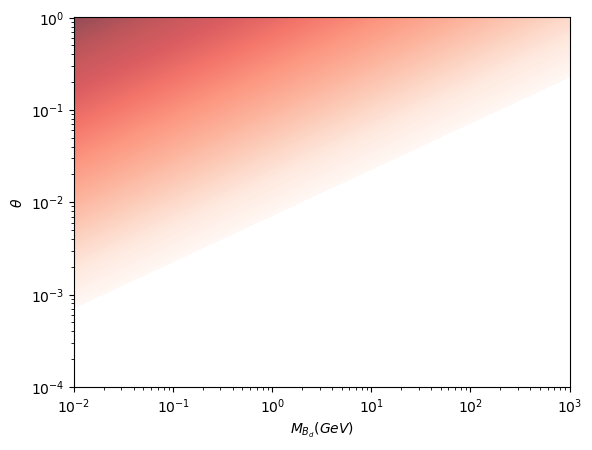

In [41]:
mx = np.logspace(-2, 3, 1000)
th = np.logspace(-4, 0, 1000)
make_tuning_plot(mx, th)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d} (GeV)$')
plt.ylabel('$\\theta$')

if save_plots:
    plt.savefig('fine_tuning_yukawa.pdf', bbox_inches='tight')


### Yukawa non-perturbativity

Similar to the tuning plot, we can add a shaded region for the region where Yukawa couplings become non-perturbative.  The condition here is

$$
\frac{y_{\rm large}^2}{4\pi} \lesssim 0.5, \\
y_{\rm \large} \equiv y(1+\epsilon),
$$
or rearranging,
$$
y_{\rm large} \lesssim \sqrt{2\pi}.
$$

Using the definition $\theta = yv/(\sqrt{2} m_{\rm eq})$, so that
$$
y = \sqrt{2} \theta \frac{m_{\rm eq}}{v}
$$
we can plot the condition vs. $\theta$.  Note that there is no $M_{B_d}$ dependence.

In practice, we likely won't use this region - it's at very large $\theta$ and we'll probably just cut off the plots.  But I'll include the code just in case.

In [42]:
def yukawa_large(theta, m_eq=m_eq_default, eps=eps_default):
    y = np.sqrt(2) * theta * m_eq / vH 
    yl = y * (1+eps)
    
    return yl
    

def plot_yukawa_bound(M_Bd, theta, m_eq=m_eq_default, eps=eps_default):
    
    M, T = np.meshgrid(M_Bd, theta, indexing='xy')
    yl = yukawa_large(T, m_eq=m_eq, eps=eps)
    
    plt.pcolormesh(M, T, np.where(yl>np.sqrt(2*np.pi), yl, np.nan), 
                   alpha=0.7, cmap=plt.colormaps['Greens'], rasterized=True)

    
    return



Text(0, 0.5, '$\\theta$')

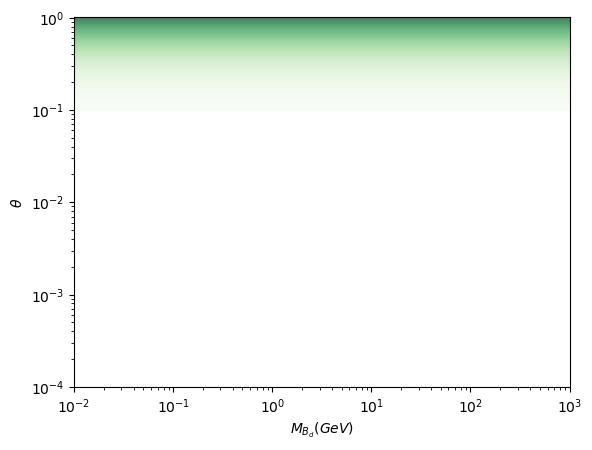

In [43]:
plot_yukawa_bound(mx, th)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d} (GeV)$')
plt.ylabel('$\\theta$')


### Contributions to Higgs potential

Finally, from the paper, we have the constraint

$$
\theta \lesssim \frac{v^2}{\sqrt{\Lambda_d^3 m_{\rm eq}}}
$$

In [44]:
def higgs_potential_bound(M_Bd, ND=ND_default, m_eq=m_eq_default, HQ=False):
    Lambda_d, _  = glueball_mass_F(M_Bd, ND=ND, HQ=HQ)
    
    return vH**2 / np.sqrt(Lambda_d**3 * m_eq)

Text(0, 0.5, '$\\theta$')

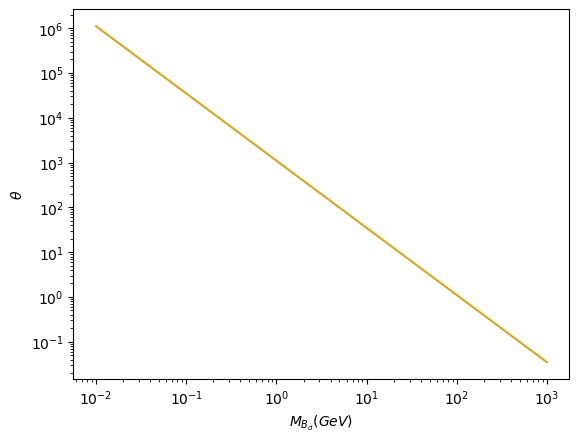

In [45]:
plt.plot(mx, higgs_potential_bound(mx), color='goldenrod')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d} (GeV)$')
plt.ylabel('$\\theta$')

# Irrelevant for the bounds below - not included in combined plot.


## Combined plot



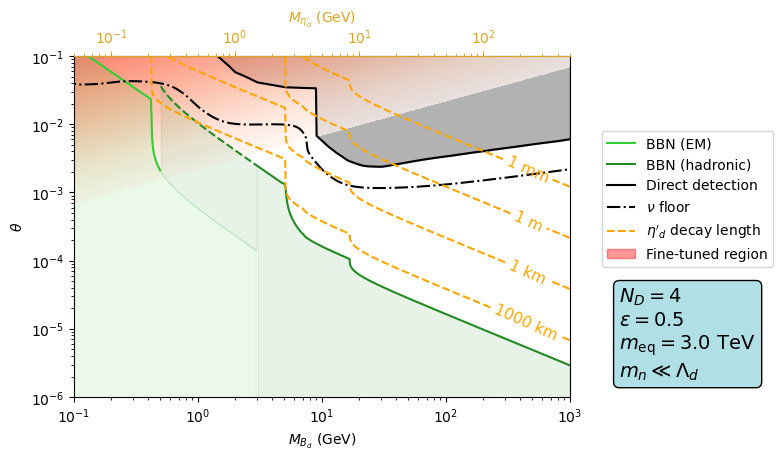

In [55]:
mx = np.logspace(-2, 3, 1000)
mx2 = np.logspace(-2, 1, 1000)

# Adjust these parameters as desired for these plots!
eps = 0.5   # 0.5 default
m_eq = 3000 # 3000 default
ND = 4      # 4 default
f = 1       # 1 default
r_Bd_eta=0.5

HQ=False
exclude_eta_decay = False  # If True, don't show decay-length contours

if HQ:
    include_glueball = True
else:
    include_glueball = False

LZB = []
NFB = []
DSB = []

for M_Bd in mx:
    LZB.append(compute_LZ_bound(M_Bd, ND=ND))
    NFB.append(compute_NF_bound(M_Bd, ND=ND))
    DSB.append(compute_DS50_bound(M_Bd, ND=ND))

BBNB_heavy = []  # BH ~ 1
BBNB_light = []  # BH ~ 0

# Mesons/glueballs
BBNB_glue_heavy = []
BBNB_glue_light = []
BBNB_sigma_heavy = []
BBNB_sigma_light = []

for M_Bd in mx:
    BBNB_heavy.append(compute_BBN_bound(M_Bd, Gamma_eta_prime, eps=eps, r_Bd_eta=0.5, ND=ND, HQ=HQ))
    BBNB_light.append(compute_BBN_bound(M_Bd, Gamma_eta_prime, eps=eps, r_Bd_eta=0.5, ND=ND, HQ=HQ, 
                                        tau_max = 1e4))
    BBNB_glue_heavy.append(compute_BBN_bound(M_Bd, Gamma_glueball, r_Bd_eta=0.5, 
                                             HQ=HQ, ND=ND))
    BBNB_glue_light.append(compute_BBN_bound(M_Bd, Gamma_glueball, r_Bd_eta=0.5, 
                                             HQ=HQ, ND=ND, tau_max = 1e4))
    BBNB_sigma_heavy.append(compute_BBN_bound(M_Bd, Gamma_sigma, m_eq=m_eq, ND=ND))
    BBNB_sigma_light.append(compute_BBN_bound(M_Bd, Gamma_sigma, m_eq=m_eq, ND=ND, tau_max = 1e4))

BBNB_heavy, BBNB_light = np.asarray(BBNB_heavy), np.asarray(BBNB_light)
BBNB_glue_heavy, BBNB_glue_light = np.asarray(BBNB_glue_heavy), np.asarray(BBNB_glue_light)
BBNB_sigma_heavy, BBNB_sigma_light = np.asarray(BBNB_sigma_heavy), np.asarray(BBNB_sigma_light)


# Combine curves
DDB = np.minimum(LZB, DSB)

BBNB_comb_heavy = np.maximum(BBNB_heavy, BBNB_sigma_heavy)
BBNB_comb_light = np.maximum(BBNB_light, BBNB_sigma_light)
if include_glueball:
    BBNB_comb_heavy = np.maximum(BBNB_comb_heavy, BBNB_glue_heavy)
    BBNB_comb_light = np.maximum(BBNB_comb_light, BBNB_glue_light)

light_region = mx <= 0.5
light_tail = np.logical_and(mx >= 0.5, mx <= 3.0)

heavy_region = mx >= 3.0
heavy_tail = np.logical_and(mx >= 0.5, mx <= 3.0)

plt.plot(mx[light_region], BBNB_comb_light[light_region], color='limegreen', label="BBΝ (EM)")
#plt.plot(mx[light_tail], BBNB_comb_light[light_tail], color='orange', ls='--')

plt.plot(mx[heavy_region], BBNB_comb_heavy[heavy_region], color='forestgreen', label="BBN (hadronic)")
plt.plot(mx[heavy_tail], BBNB_comb_heavy[heavy_tail], color='forestgreen', ls='--' )
    
plt.plot(mx, DDB, color='k', label='Direct detection')
plt.plot(mx, NFB, color='k', ls='-.', label='$\\nu$ floor')


#plt.plot([], [], color='red', label='Fine-tuning', ls=':') #, label='Fine-tuning (light-mass limit)', ls=':')

plt.xlim(1e-1,1e3)
plt.ylim(1e-6,1e-1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{B_d}\ ({\\rm GeV})$')
plt.ylabel('$\\theta$')




ax = plt.gca()

ax.set_aspect(0.55)
ax.fill_between(mx, DDB, 100, color='k', alpha=0.3)
#ax.fill_between(mx, MHB, 100, color='red', alpha=0.05)
#ax.fill_between(mx, MHB, 100, color='red', alpha=np.linspace(0,1,len(mx)))

th = np.logspace(-4, 0, 1000)
th2 = np.logspace(-7, 0, 1000)
make_tuning_plot(mx, th, m_eq=m_eq, HQ=HQ)

if not exclude_eta_decay:
    draw_decay_lengths(mx, th2, r_Bd_eta=r_Bd_eta, eps=eps, ND=ND, HQ=HQ)
    if HQ:
        plt.plot([], [], color='indigo', label="$0^{++}_d$ decay length", ls='--')     
    else:
        plt.plot([], [], color='orange', label="$\\eta'_d$ decay length", ls='--') 

ax.fill_between(mx[mx <= 3.0], BBNB_comb_light[mx <= 3.0], color='limegreen', alpha=0.1)
ax.fill_between(mx[mx >= 3.05], BBNB_comb_heavy[mx >= 3.05], color='forestgreen', alpha=0.1)
ax.fill_between(mx[np.logical_and(mx >= 0.5, mx <= 3.0)], 
                BBNB_comb_heavy[np.logical_and(mx >= 0.5, mx <= 3.0)], 
                BBNB_comb_light[np.logical_and(mx >= 0.5, mx <= 3.0)],
                color='forestgreen', alpha=0.1)


# Add eta-prime axis at the top
def baryon_to_eta(M_Bd):
    return M_Bd * 2 / ND

def eta_to_baryon(m_eta):
    return m_eta * ND / 2

def baryon_to_glueball(M_Bd):
    # Only used in light-glue/heavy-quark limit
    return M_Bd / ND

def glueball_to_baryon(m_G):
    # As above
    return m_G * ND

if(HQ):
    ax2 = ax.secondary_xaxis('top', functions=(baryon_to_glueball, glueball_to_baryon))
    ax2.set_xlabel("$M_{0^{++}_d}\ ({\\rm GeV})$")
    ax2.tick_params(axis='x', which='both', colors='indigo')
    ax2.xaxis.label.set_color('indigo')
    ax.spines['top'].set_color('indigo')   
else:
    ax2 = ax.secondary_xaxis('top', functions=(baryon_to_eta, eta_to_baryon))
    ax2.set_xlabel("$M_{\\eta_d'}\ ({\\rm GeV})$")
    ax2.tick_params(axis='x', which='both', colors='goldenrod')
    ax2.xaxis.label.set_color('goldenrod')
    ax.spines['top'].set_color('goldenrod')


#plt.scatter(bench[:,0], bench[:,1], marker='x', color='black', label='Benchmark points')

# Monkey patch the legend to add the fine-tuning label not as just a line...
handles, labels = plt.gca().get_legend_handles_labels()
ft_patch = mpatches.Patch(color='red', alpha=0.4, label='Fine-tuned region')   
handles.extend([ft_patch])

plt.legend(loc='upper left', bbox_to_anchor=(1.05,0.80), handles=handles)

mass_limit_str = r'$m_n \gg \Lambda_d$' if HQ else r'$m_n \ll \Lambda_d$'

# Label model params used
info_str = '\n'.join([
    f'$N_D = {ND}$',
    f'$\\epsilon = {eps}$',
    '$m_{\\rm eq}' + f' = {m_eq/1000}$ TeV',
    mass_limit_str,
])

ax.text(1.1, 0.06, info_str, transform=ax.transAxes, fontsize=14, 
        bbox={'boxstyle': 'round', 'facecolor': 'powderblue'})

if save_plots:
    filename = f'HSDM_bounds_ND{ND}_eps{eps}_meq{m_eq/1000}'    
    if HQ:
        filename += '_hq'
    if exclude_eta_decay:
        filename += '_nodecay'
    filename += '.pdf'

    plt.savefig(filename, bbox_inches='tight')